#### ***IMPORT DEPENDENCIES***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

/Users/mohana25/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
'''Initialize k means with random values
--> For a given number of iterations:
    
    --> Iterate through items:
    
        --> Find the mean closest to the item by calculating 
        the euclidean distance of the item with each of the means
        
        --> Assign item to mean
        
        --> Update mean by shifting it to the average of the items in that cluster'''

#### ****DATA FILTERING****

In [3]:
#THIS WAS DONE JUST FOR REFERENCE
import csv
with open('clustering_data.csv' , 'r') as fq, open('cluster_mod.csv', 'w') as frev :
    sep = csv.writer(frev, delimiter = ',')
    for point in csv.reader(fq, delimiter = ',') :
        if point[8] == 'ANDHRA PRADESH' :
            sep.writerow(point)

In [3]:
df = pd.read_csv("clustering_data.csv", na_values=['NA'])

new_df = df.loc[(df["StateName"]=="ANDHRA PRADESH")]

new_df['Latitude'] = new_df['Latitude'].str.strip()
new_df['Longitude'] = new_df['Longitude'].str.strip()

new_df['Latitude'] = pd.to_numeric(new_df['Latitude'], errors='coerce')
new_df['Longitude'] = pd.to_numeric(new_df['Longitude'], errors='coerce')

new_df = new_df.loc[(new_df['Latitude'] <= 20) & (new_df['Latitude'] >= 10)]
new_df = new_df.loc[(new_df['Longitude'] <= 84) & (new_df['Longitude'] >= 74)]
new_df_cl = new_df.dropna(subset=['Latitude'])
new_df_cl = new_df.dropna(subset=['Longitude'])

new_df_cl = new_df.reset_index(drop=True)
lat = new_df_cl["Latitude"].interpolate()
long = new_df_cl['Longitude'].interpolate()
#print(new_df_cl)
#print(max(lat), max(long))
print(len(new_df_cl))

7941


/var/folders/8j/2bschcy91hl2lzf_yf5v4gb00000gn/T/ipykernel_64743/2303283073.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("clustering_data.csv", na_values=['NA'])
/var/folders/8j/2bschcy91hl2lzf_yf5v4gb00000gn/T/ipykernel_64743/2303283073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Latitude'] = new_df['Latitude'].str.strip()
/var/folders/8j/2bschcy91hl2lzf_yf5v4gb00000gn/T/ipykernel_64743/2303283073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

#### ****DATA VISUALISATION****

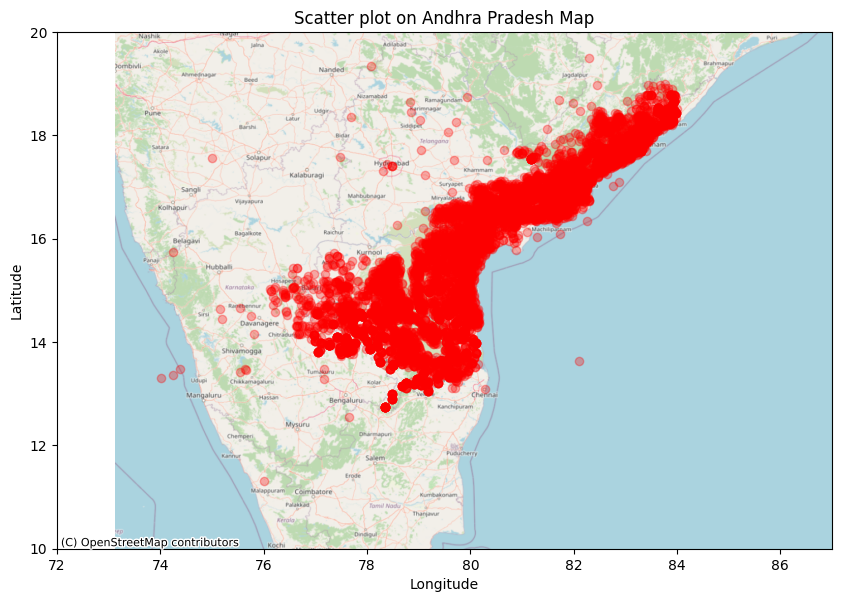

In [4]:
#Creating GeoPandas dataframe
gdf = gpd.GeoDataFrame(new_df_cl, geometry=gpd.points_from_xy(new_df_cl.Longitude, new_df_cl.Latitude))

# Set the CRS to EPSG:4326 (WGS 84)
gdf.set_crs(epsg=4326, inplace=True)

# Plot the points
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', alpha=0.3)

#Print available providers to choose from
#print(ctx.providers.keys())

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set the x and y limits to focus on Andhra Pradesh
ax.set_xlim(72.0, 87.0)
ax.set_ylim(10.0, 20.0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Scatter plot on Andhra Pradesh Map')

plt.show()

#### ***K-Means Clustering***

In [9]:
#Prepare data properly
x = new_df_cl["Latitude"].interpolate()
y = new_df_cl["Longitude"].interpolate()
sample = np.array(list(zip(x, y)))
#print(len(sample))

# Making random centroids first
k = 5  #number of clusters

#centroid = np.random.rand(k, 2)
#print(centroid)

#Creating random centroids in a particular range
centroids_x = np.random.uniform(min(x),max(x),k)
centroids_y = np.random.uniform(min(y),max(y),k)
centroid = np.array(list(zip(centroids_x, centroids_y)))

#Defining distance
def distance(a,b) :
    x = (a[0]-b[0])**2
    y = (a[1]-b[1])**2
    distances = (x+y)**0.5
    return distances

#Initialising
error = np.zeros(k)
distances = np.zeros(k)
label = np.zeros(len(sample))
centroids_new = np.zeros_like(centroid)

for _ in range(150) :
    #Giving labels to points
    for i, t in enumerate(sample):
        distances = [distance(t, z) for z in centroid]
        label[i] = np.argmin(distances)
    new_df_cl['Cluster'] = label
    #print(label)
    
    #finding new centroids as mean
    for i in range(k) :
        #print(points)
        points = [sample[j] for j in range(len(sample)) if label[j] == i]
        if len(points) > 0 :
            centroids_new[i] = np.mean(points, axis=0)
        else :
            centroids_new[i] = np.random.rand(2)
        #print(points)
    centroid = centroids_new
print(centroid)

[[18.03380325 83.17237107]
 [16.88390223 81.54477748]
 [16.02857619 79.89423674]
 [14.08023152 79.33417988]
 [14.56484842 77.83486093]]


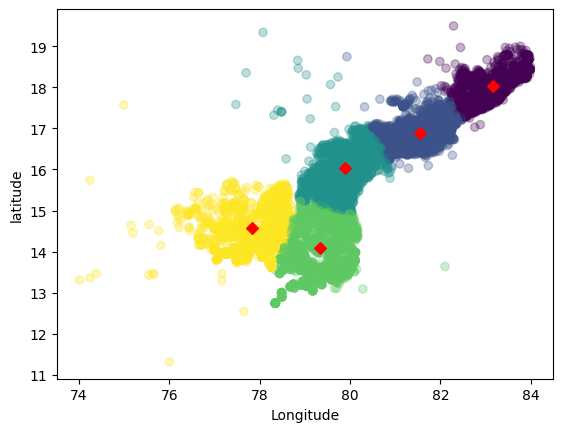

In [10]:
#plotting the results
plt.scatter(sample[:,1],sample[:,0], c= label,alpha=0.3)
plt.scatter(centroid[:, 1],centroid[:, 0],marker='D',c='red')
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.show()

18.03380325417494 83.17237106964734
16.883902234614506 81.54477747832267
16.02857619272144 79.8942367437227
14.080231520791386 79.33417988462648
14.56484841893762 77.83486092727193


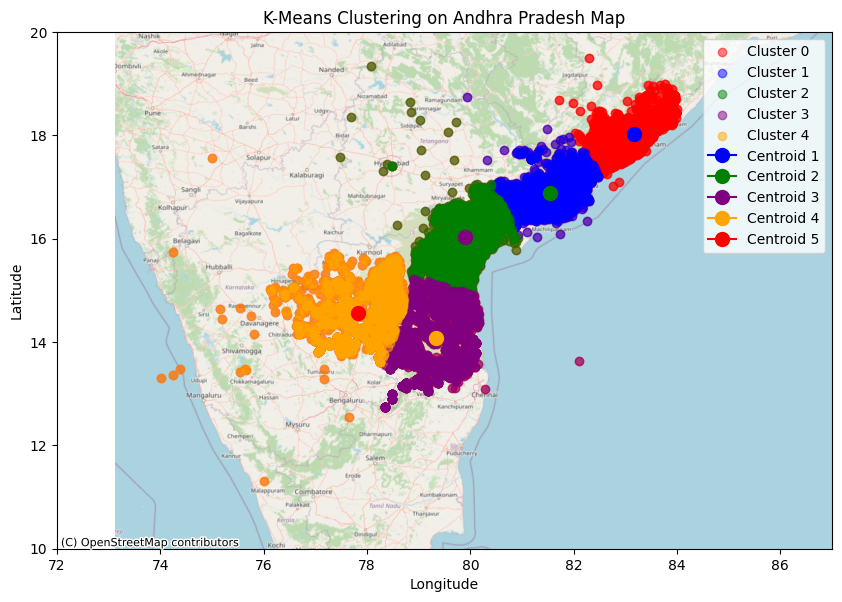

In [12]:
#Creating GeoPandas dataframe
gdf = gpd.GeoDataFrame(new_df_cl, geometry=gpd.points_from_xy(new_df_cl.Longitude, new_df_cl.Latitude))

# Set the CRS to EPSG:4326 (WGS 84)
gdf.set_crs(epsg=4326, inplace=True)

# Plot the points
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', alpha=0.5)

# Convert centroids to a GeoDataFrame
centroid_gdf = gpd.GeoDataFrame(centroid, columns=['Latitude', 'Longitude'],geometry=gpd.points_from_xy(centroid[:, 1], centroid[:, 0]))
centroid_gdf.set_crs(epsg=4326, inplace=True)

# Plot each cluster with a different color
colors = ['red', 'blue', 'green', 'purple', 'orange']
for cluster in range(k):
    cluster_data = gdf[gdf['Cluster'] == cluster]
    cluster_data.plot(ax=ax, color=colors[cluster], alpha=0.5, label=f'Cluster {cluster}')


centroid_colors = ['blue', 'green', 'purple', 'orange', 'red']  # Adjust based on k
for i in range(k):
    centroid_lon = centroid_gdf.iloc[i].geometry.x
    centroid_lat = centroid_gdf.iloc[i].geometry.y
    print(centroid_lat, centroid_lon)
    ax.plot(centroid_lon, centroid_lat, marker='o', markersize=10, color=centroid_colors[i], label=f'Centroid {i+1}')

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set the x and y limits to focus on Andhra Pradesh
ax.set_xlim(72.0, 87.0)
ax.set_ylim(10.0, 20.0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('K-Means Clustering on Andhra Pradesh Map')
ax.legend()

plt.show()